05/12/2020

to do is to add the tf colors into the plots

In [2]:
library(tidyverse)
library(pheatmap)


library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)

In [3]:
save_prefix = '../data/processed/fig4_modelling/'

# Get stability score pairs

In [4]:
tfs_short = sort(unique(read.csv('../data/processed/fig3_footprinting/overall_df_go_filt_with_groups.csv',header=TRUE)$tf))
tfs = read.csv('../data/processed/fig3_footprinting/select_TFs.csv',header=FALSE)$V1
length(tfs_short)
length(tfs)

[1] 73

[1] 92

In [5]:
tissue_colors = read.csv( '../data/processed/fig3_footprinting/tissue_colors.csv',stringsAsFactors=F)
tissue_colors

tissue,color
<chr>,<chr>
Airway,#4A195D
Astrocytes,#A8EAFF
Bladder,#C2A7D2
Colon,#F5AF1A
Esophageal,#FFDA89
GDSD0,#240201
GDSD3,#4E0A05
GDSD6,#A22633
GM12878,#8F99AC


In [6]:
# rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
# rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
# rna_df_tissue_log = log2(rna_df_tissue+1e-2)
# rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))
# # rna_df_tissue_norm

In [7]:
# colnames(rna_df_tissue_norm)

In [8]:
THRES=0.1

In [9]:
dir = '../data/processed/fig4_modelling/irf_manual/'
list.files(dir,pattern='*stability_score.csv')
files_to_check = c('test_Airway_purple_stability_score.csv',
                   'test_Astrocytes_blue_stability_score.csv',
                   'test_Colon_green_stability_score.csv',
                   'test_GDSD6_purple_stability_score.csv',
                   'test_GM12878_grey_stability_score.csv',
                   'test_Melanocytes_blue_stability_score.csv'
                  )

[1] "test_Airway_purple_stability_score.csv"   
[2] "test_Astrocytes_blue_stability_score.csv" 
[3] "test_Bladder_purple_stability_score.csv"  
[4] "test_Colon_green_stability_score.csv"     
[5] "test_GDSD6_purple_stability_score.csv"    
[6] "test_GM12878_grey_stability_score.csv"    
[7] "test_Melanocytes_blue_stability_score.csv"
[8] "test_Prostate_purple_stability_score.csv" 
[9] "test_Uterine_purple_stability_score.csv"

In [10]:
read_stability_file = function(filepath, thres=THRES, num_element = 2){
#     irf_results_file = paste0(dir, 'test_',tissue,'_',group,'_stability_score.csv')
    file = tail(strsplit(filepath, '/')[[1]],n=1)
    arr = strsplit(file, '_')[[1]]
    tissue = arr[2]
    group = arr[3]
    
    
    irf_results_df = read.csv(filepath,header=FALSE)
    colnames(irf_results_df) = c('interaction','score')
    irf_results_df$interaction = as.character(irf_results_df$interaction )
    irf_results_df$num_elements =  sapply(irf_results_df$interaction, function (x) length(strsplit(x,'::')[[1]]))
    irf_results_df = irf_results_df%>%
        filter(num_elements == num_element)%>%
        filter(score>thres)
    irf_results_df$num_int = 1:dim(irf_results_df)[1]
    irf_results_df$tissue = tissue                                     
    irf_results_df$group = group 
    if (num_element==2){
    irf_results_df = irf_results_df %>% 
        separate( interaction, into = c("tf1", "tf2"), sep = "::")%>%
        separate( tf1, into = c("tf1_name", "tf1_type"), sep = "_")%>%
        separate( tf2, into = c("tf2_name", "tf2_type"), sep = "_")}
    return(irf_results_df)
}

In [11]:

stability_df_overall =data.frame()
for (file in files_to_check){
    
    irf_filepath = paste0(dir, file)
    
    stability_df = read_stability_file(irf_filepath,thres=0.05)
    stability_df_overall = rbind(stability_df_overall, stability_df)

}
stability_df_overall = filter(stability_df_overall, (tf1_name %in% tfs_short) | (tf2_name %in% tfs_short) )
stability_df_overall$num_int_overall = 1:dim(stability_df_overall)[1]
stability_df_overall = left_join(stability_df_overall, tissue_colors, by='tissue')
dim(stability_df_overall)

[1] 38 11

In [13]:
stability_df_overall_long1 = stability_df_overall[,c("tf1_name",'score','num_int_overall','tissue','group','color')]
colnames(stability_df_overall_long1) = c("tf_name",'score','num_int_overall','tissue','group','color')
stability_df_overall_long2 = stability_df_overall[,c("tf2_name",'score','num_int_overall','tissue','group','color')]
colnames(stability_df_overall_long2) = c("tf_name",'score','num_int_overall','tissue','group','color')
stability_df_overall_long = rbind(stability_df_overall_long1, stability_df_overall_long2)

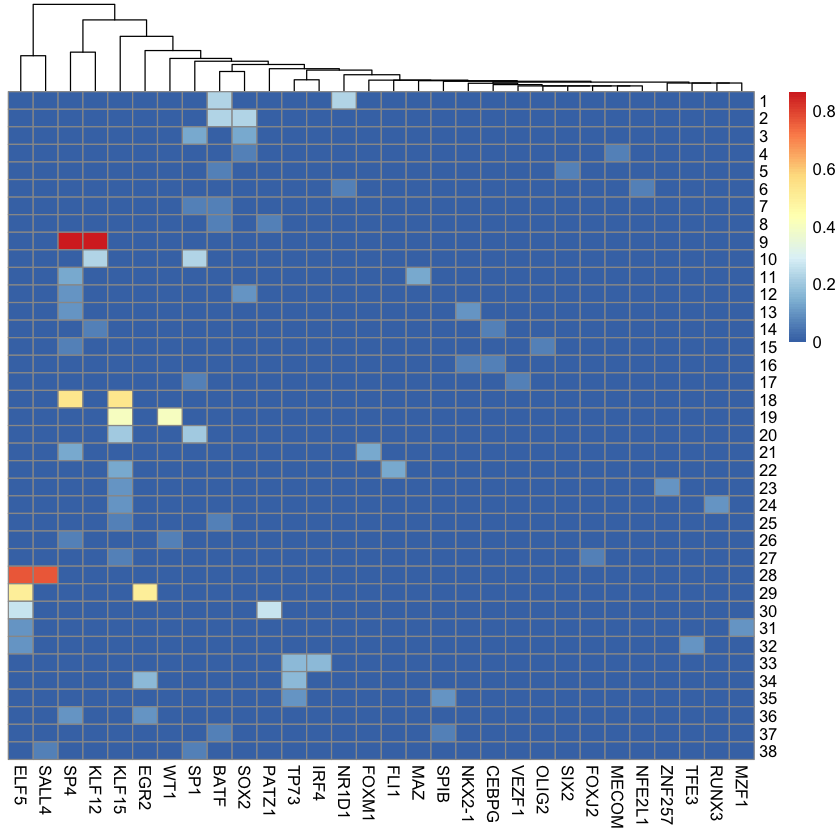

In [14]:
stability_df_overall_spread = stability_df_overall_long%>%
    dplyr::select(tf_name, score,num_int_overall)%>%
    pivot_wider(names_from = tf_name, values_from = score)%>%
    column_to_rownames("num_int_overall")
stability_df_overall_spread[is.na(stability_df_overall_spread)] = 0
p = pheatmap(stability_df_overall_spread,
        cluster_row=F)
tf_order = colnames(stability_df_overall_spread)[p$tree_col[['order']]]

In [108]:
tissue_colors_filt = filter(tissue_colors, tissue %in%unique(stability_df_overall_long$tissue))
tissue_colors_filt

tissue,color
<chr>,<chr>
Airway,#4A195D
Astrocytes,#A8EAFF
Colon,#F5AF1A
GDSD6,#A22633
GM12878,#8F99AC
Melanocytes,#189BDD


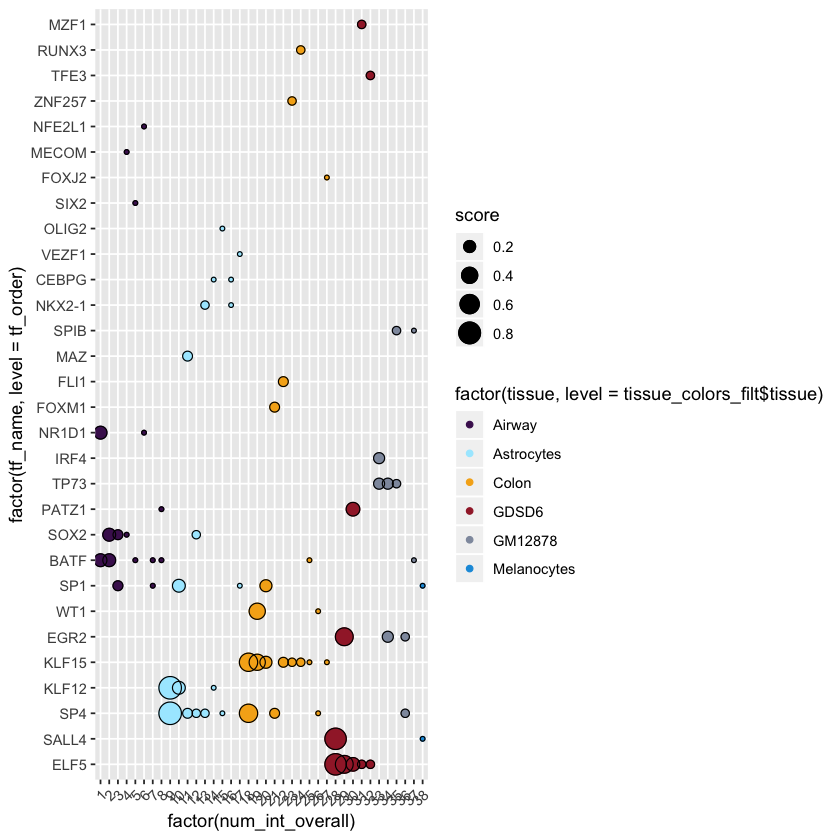

In [119]:
p = ggplot(stability_df_overall_long, aes(x= factor(num_int_overall),y=factor(tf_name,level=tf_order),
                                          color=factor(tissue, level=tissue_colors_filt$tissue)))+
    geom_point(aes(size=score))+
    scale_color_manual(values=tissue_colors_filt$color)+
    geom_point(aes(size=score),colour="black",pch=21)+
    theme(axis.text.x = element_text(angle = 45,hjust=1))
p 
ggsave(file = paste0(save_prefix, "stability_df_by_tissue_pairs.eps"),height=5, width=10)
#

In [50]:
# tissue='GDSD6'
# group = 'purple'
# irf_results_file = paste0(dir, 'test_',tissue,'_',group,'_stability_score.csv')
# irf_results_df = read.csv(irf_results_file,header=FALSE)
# colnames(irf_results_df) = c('interaction','score')
# irf_results_df$interaction = as.character(irf_results_df$interaction )
# irf_results_df$num_elements =  sapply(irf_results_df$interaction, function (x) length(strsplit(x,'::')[[1]]))
# irf_results_df = irf_results_df%>%
#     filter(num_elements ==2)%>%
#     filter(score>THRES)
# irf_results_df$num_int = 1:dim(irf_results_df)[1]
# irf_results_df$tissue = tissue                                     
# irf_results_df$group = group                                     
# irf_results_df = irf_results_df %>% 
#     separate( interaction, into = c("tf1", "tf2"), sep = "::")%>%
#     separate( tf1, into = c("tf1_name", "tf1_type"), sep = "_")%>%
#     separate( tf2, into = c("tf2_name", "tf2_type"), sep = "_")


In [82]:
# split_names = data.frame(t(sapply(irf_results_df$interaction, function (x) strsplit(x,'::')[[1]])))
# colnames(split_names) = c('tf1','tf2')
# within(split_names, tf1<-data.frame(do.call('rbind', strsplit(as.character(tf1), '_', fixed=TRUE))))

                                  
# #,col.names=c('tf1','tf2'))

In [47]:
p_dot_tissue = ggplot(overall_df_go_filt_with_groups, aes(x=factor(Description,level=go_term_ordering_sel), y = factor(tf,level=tf_ordering),
                                                   color=factor(tissue, level=tissue_colors$tissue)))+
    geom_point(aes(size=log10_pval))+
    scale_color_manual(values=tissue_colors$color)+
    theme(axis.text.x = element_text(angle = 45,hjust=1))
p_dot_tissue
ggsave(file = paste0(save_prefix, "overall_df_regrouped_go_reduced_bytissue.eps"),height=20, width=15)
# # level_order <- c('virginica', 'versicolor', 'setosa') #this vector might be useful for other plots/analyses
# ggplot(overall_df_regrouped_go, aes(x = factor(Description, y = tf)) + 
#      geom_point(aes( size=log10_pval)) +#,colour="black",pch=21)
#   theme(axis.text.x = element_text(angle = 45))
# #   scale_size_area(max_size = 10)

,tf1,tf2
,<fct>,<fct>
EGR2_loop::SPIB_loop,EGR2_loop,SPIB_loop
EGR2_loop::IRF4_loop,EGR2_loop,IRF4_loop
EGR2_loop::ZNF467_loop,EGR2_loop,ZNF467_loop
EGR2_loop::PATZ1_loop,EGR2_loop,PATZ1_loop
TP73_loop::IRF4_loop,TP73_loop,IRF4_loop
EGR2_loop::TP73_loop,EGR2_loop,TP73_loop
IRF4_loop::SPIB_loop,IRF4_loop,SPIB_loop
EGR2_loop::IKZF1_loop,EGR2_loop,IKZF1_loop
EGR2_loop::KLF9_loop,EGR2_loop,KLF9_loop


# get go terms associateed with stability score pairs chosen

05/14/2020

In [19]:
stability_df_overall

tf1_name,tf1_type,tf2_name,tf2_type,score,num_elements,num_int,tissue,group,num_int_overall,color
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<int>,<chr>
NR1D1,loop,BATF,loop,0.23333333,2,7,Airway,purple,1,#4A195D
BATF,loop,SOX2,loop,0.23333333,2,8,Airway,purple,2,#4A195D
SP1,loop,SOX2,loop,0.13333333,2,10,Airway,purple,3,#4A195D
MECOM,pro,SOX2,loop,0.06666667,2,15,Airway,purple,4,#4A195D
BATF,loop,SIX2,loop,0.06666667,2,17,Airway,purple,5,#4A195D
NFE2L1,pro,NR1D1,loop,0.06666667,2,19,Airway,purple,6,#4A195D
SP1,loop,BATF,loop,0.06666667,2,21,Airway,purple,7,#4A195D
PATZ1,loop,BATF,loop,0.06666667,2,22,Airway,purple,8,#4A195D
SP4,loop,KLF12,loop,0.86666667,2,1,Astrocytes,blue,9,#A8EAFF


In [14]:
all_genes = read.csv(paste0('../data/processed/fig1/rna/','all', '_genes.csv'),header=FALSE,stringsAsFactors=F)$V1
all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID


'select()' returned 1:many mapping between keys and columns



In [21]:
find_genes = function(row, bck_genes_entrez = all_entrez, crm_file_loc= '../data/processed/tissue_crms/pro_loop_tissue/',crm_file_suffix='_crm.csv'){
#     bck_genes = read.csv(paste0('../data/processed/fig1/rna/',group, '_genes.csv'),header=FALSE,stringsAsFactors=F)$V1

    crm_df = read.csv(paste0(crm_file_loc, row['tissue'], crm_file_suffix),row.names=1)
    tf1_col = paste(row['tf1_name'], row['tf1_type'], sep='_')
    tf2_col = paste(row['tf2_name'], row['tf2_type'], sep='_')
    genes_tf1 = rownames(crm_df)[crm_df[,tf1_col]>0]
    genes_tf2 = rownames(crm_df)[crm_df[,tf2_col]>0]
    target_genes = intersect(genes_tf1,genes_tf2)
    print(target_genes)
    target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
    print(tf1_col)
    print(tf2_col)
    print(row['tissue'])
    print(length(target_genes_entrez))
    ego <- enrichGO(gene          = target_genes_entrez,
    universe      = bck_genes_entrez,
    OrgDb         = org.Hs.eg.db,
    ont           = "BP",
    pAdjustMethod = "BH",
    pvalueCutoff  = 0.05,
    qvalueCutoff  = 0.2,
    readable=TRUE)
    er_df = data.frame(ego)
    print(dim(er_df)[1])
    return (er_df)
}

In [22]:
find_genes(stability_df_overall[1,])


 [1] "ACTN1"          "ADRA1B"         "AKR1B1"         "AP3D1"         
 [5] "APOF"           "ARHGDIA"        "ARL4D"          "ATL1"          
 [9] "BAG1"           "BARX2"          "CAMK1D"         "CAV1"          
[13] "CAV2"           "CCDC57"         "CCDC91"         "CHMP5"         
[17] "CTDSP2"         "CTRC"           "CUBN"           "CUEDC1"        
[21] "CWH43"          "CYB5D1"         "DCAKD"          "DDIT4"         
[25] "DOT1L"          "DUSP7"          "DYNC1LI2"       "ERGIC1"        
[29] "ETS2"           "EVA1A"          "FAM207A"        "FOPNL"         
[33] "FSTL3"          "GALNT4"         "GSN"            "HKDC1"         
[37] "ITGA2"          "ITGB2"          "ITPRIP"         "KCNN4"         
[41] "LGR4"           "LSM10"          "MFHAS1"         "MICAL2"        
[45] "NFIL3"          "NKX2-1"         "NMT1"           "NXN"           
[49] "PEX26"          "PGAM1"          "PLK2"           "POC1B-GALNT4"  
[53] "PRRC2C"         "PTP4A2"         "RAB14"     

'select()' returned 1:1 mapping between keys and columns



[1] "NR1D1_loop"
[1] "BATF_loop"
  tissue
1 Airway
[1] 79
[1] 2


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031579,GO:0031579,membrane raft organization,4/72,23/17715,2.094805e-06,0.004047164,0.003541324,CAV1/CAV2/GSN/S100A10,4
GO:0001765,GO:0001765,membrane raft assembly,3/72,12/17715,1.379532e-05,0.013326278,0.011660675,CAV1/CAV2/S100A10,3


In [24]:
find_genes(stability_df_overall[28,])


  [1] "A4GALT"         "ABCA7"          "ABCB6"          "ABCB8"         
  [5] "ABRA"           "ACAA1"          "ACAA2"          "ACADS"         
  [9] "ACP2"           "ACTN1"          "ACTN4"          "ADAM15"        
 [13] "ADM5"           "AJUBA"          "ALDH1A2"        "ALS2CL"        
 [17] "AMHR2"          "AMIGO1"         "ANKRD11"        "ANKRD22"       
 [21] "ANKRD63"        "ANKZF1"         "ANO6"           "AP2S1"         
 [25] "AQP3"           "ARF6"           "ARHGEF15"       "ARID3A"        
 [29] "ARID3C"         "ARL2"           "ARL5B"          "ARMC12"        
 [33] "ARPC1A"         "ARPC5L"         "ASIC1"          "ASTE1"         
 [37] "ATG9A"          "ATXN3L"         "AURKC"          "AXL"           
 [41] "B3GNT3"         "B4GALNT3"       "B4GALT1"        "B9D1"          
 [45] "BANF1"          "BARX2"          "BCAN"           "BCL2L11"       
 [49] "BEAN1"          "CANX"           "CAP1"           "CAPS"          
 [53] "CAPZA1"         "CATSPER1"     

'select()' returned 1:1 mapping between keys and columns



[1] "ELF5_loop"
[1] "SALL4_loop"
   tissue
28  GDSD6
[1] 581
[1] 6


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0070268,GO:0070268,cornification,19/528,112/17715,7.993250e-10,3.483458e-06,3.351275e-06,KLK13/KLK5/KRT12/KRT13/KRT14/KRT16/KRT17/KRT19/KRT23/KRT31/KRT33A/KRT33B/KRT34/KRT39/KRT6B/KRT81/KRT82/KRT9/PPL,19
GO:0009913,GO:0009913,epidermal cell differentiation,33/528,358/17715,9.891891e-09,2.155443e-05,2.073653e-05,AQP3/IL20/KLF4/KLF7/KLK13/KLK5/KRT12/KRT13/KRT14/KRT16/KRT17/KRT19/KRT23/KRT31/KRT33A/KRT33B/KRT34/KRT39/KRT6B/KRT81/KRT82/KRT9/KRTAP16-1/KRTAP4-6/LRTOMT/MAFF/NUMA1/PPL/PSAP/SHARPIN/TRIOBP/ZFP36/ZFP36L1,33
GO:0008544,GO:0008544,epidermis development,38/528,464/17715,1.904449e-08,2.766530e-05,2.661551e-05,AQP3/FLG2/IL20/KLF4/KLF7/KLK13/KLK5/KLK7/KRT12/KRT13/KRT14/KRT16/KRT17/KRT19/KRT23/KRT31/KRT33A/KRT33B/KRT34/KRT39/KRT6B/KRT81/KRT82/KRT9/KRTAP16-1/KRTAP4-6/LRTOMT/MAFF/NAB2/NUMA1/POU2F3/PPARD/PPL/PSAP/SHARPIN/TRIOBP/ZFP36/ZFP36L1,38
GO:0030216,GO:0030216,keratinocyte differentiation,28/528,305/17715,1.440029e-07,1.568912e-04,1.509378e-04,AQP3/IL20/KLK13/KLK5/KRT12/KRT13/KRT14/KRT16/KRT17/KRT19/KRT23/KRT31/KRT33A/KRT33B/KRT34/KRT39/KRT6B/KRT81/KRT82/KRT9/KRTAP16-1/KRTAP4-6/NUMA1/PPL/PSAP/SHARPIN/ZFP36/ZFP36L1,28
GO:0031424,GO:0031424,keratinization,22/528,224/17715,1.019139e-06,8.882812e-04,8.545745e-04,KLK13/KLK5/KRT12/KRT13/KRT14/KRT16/KRT17/KRT19/KRT23/KRT31/KRT33A/KRT33B/KRT34/KRT39/KRT6B/KRT81/KRT82/KRT9/KRTAP16-1/KRTAP4-6/PPL/SHARPIN,22
GO:0043588,GO:0043588,skin development,31/528,419/17715,3.426091e-06,2.488484e-03,2.394056e-03,ABCB6/AQP3/FLG2/IL20/KLK13/KLK5/KRT12/KRT13/KRT14/KRT16/KRT17/KRT19/KRT23/KRT31/KRT33A/KRT33B/KRT34/KRT39/KRT6B/KRT81/KRT82/KRT9/KRTAP16-1/KRTAP4-6/NUMA1/PPL/PSAP/RYR1/SHARPIN/ZFP36/ZFP36L1,31


In [23]:
find_genes(stability_df_overall[33,])

# if (dim(er_df)[1] >0){
#     er_df$tf = tf
#     er_df$tissue = tissue
#     er_df$num_target_genes = length(target_genes_entrez)
#     rownames(er_df) = NULL
#     overall_df_go = rbind(overall_df_go, er_df)
# }

  [1] "AAAS"        "ABHD12B"     "ABI3"        "ACSL1"       "ADAT3"      
  [6] "AMH"         "AMHR2"       "ANGPTL6"     "AP3D1"       "ARF6"       
 [11] "ARHGAP9"     "ARHGDIB"     "ARMC12"      "ATRIP"       "AUP1"       
 [16] "AZIN1"       "B3GNT7"      "BCL6B"       "BTG1"        "BTLA"       
 [21] "CACNA1I"     "CAPS"        "CASP6"       "CBLB"        "CBLC"       
 [26] "CCDC141"     "CCDC142"     "CCR10"       "CCR5"        "CCR7"       
 [31] "CD27"        "CDC37"       "CDKL3"       "CDX1"        "CENPT"      
 [36] "COL9A3"      "CRB2"        "CRYGS"       "DAND5"       "DDIT4"      
 [41] "DDX41"       "DHX9"        "DIRAS1"      "DNAJC14"     "DNAJC5B"    
 [46] "DOK1"        "DOT1L"       "DQX1"        "DUSP12"      "DUSP26"     
 [51] "EFEMP2"      "EIF2D"       "ELL2"        "ENTHD1"      "EPOR"       
 [56] "ERF"         "ESYT1"       "ETV6"        "EXOSC4"      "FAM114A1"   
 [61] "FAM166B"     "FAM83F"      "FBXW7"       "FCGR2A"      "FCGR3A"     
 [66] "FCGR3

'select()' returned 1:1 mapping between keys and columns



[1] "TP73_loop"
[1] "IRF4_loop"
    tissue
33 GM12878
[1] 208
[1] 1


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0045619,GO:0045619,regulation of lymphocyte differentiation,10/182,167/17715,8.988696e-06,0.02559082,0.02400455,AP3D1/CD27/IL4/LOXL3/MMP14/PNP/RUNX3/TNFSF4/ZFP36L1/ZFP36L2,10


In [61]:
er_df

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031579,GO:0031579,membrane raft organization,4/72,23/17715,2.094805e-06,0.004047164,0.003541324,CAV1/CAV2/GSN/S100A10,4
GO:0001765,GO:0001765,membrane raft assembly,3/72,12/17715,1.379532e-05,0.013326278,0.011660675,CAV1/CAV2/S100A10,3
